# Predicting High Priority 911 Calls in Seattle With Data From 2016-2019

In [332]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

## Creating a Baseline LightGBM Model
__I chose to use LightGBM due to its robustness against outliers, sequential tree-building, training speed, and assumptions__

Scores for Baseline Model
R^2                   0.21
RMSE                317.79
MAE                 218.60
TrainingTime(sec)     9.15
dtype: float64


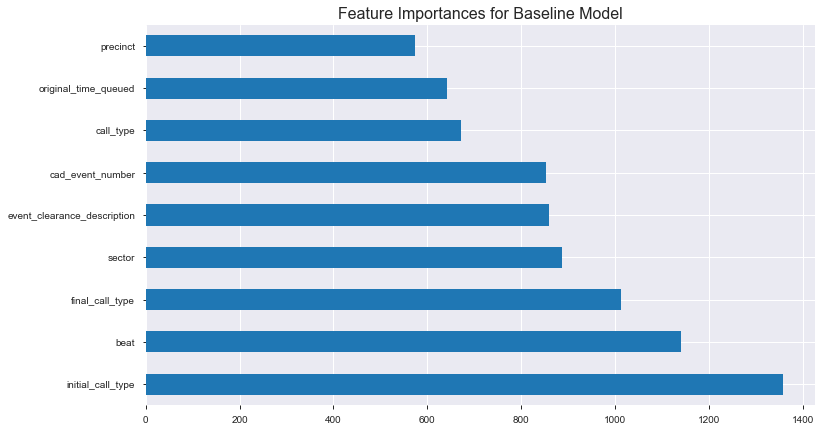

In [302]:
#read in data
df = pd.read_csv('Call_Data.csv')

def clean_df(df):
    
    #subset the df to include only calls of priority 1
    df= df[df['Priority'] == 1]
    
    #drop the priority column
    df = df.drop('Priority', axis = 1)
    
    #drop nulls
    df = df.dropna()
    
    #lower-case entire dataset
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    
    #lower-case column names
    df.columns = [c.lower() for c in df.columns]
    
    #replace space with underbar in columns
    df.columns = [c.replace(' ', '_') for c in df.columns]
    
    #convert que time to datetime
    df['original_time_queued'] = pd.to_datetime(df['original_time_queued'])
    
    #create datetime object from arrived time
    df['arrived_time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
    
    #engineering target feature response time
    df['total_response_time'] = df['arrived_time'] - df['original_time_queued']
    
    #create response time in seconds
    df['total_response_time'] = df['total_response_time'].dt.total_seconds()
    
    #make df for only the last three years
    df = df[df['original_time_queued'].dt.year > 2015]
    
    #just drop the response times that are negative or 0
    to_drop = df[df['total_response_time'] < 0]

    df.drop(to_drop.index, inplace = True)
    
    #reset the index since we dropped negative response times
    df.reset_index(drop = True, inplace = True)
    
    #outlier function
    def z_score_indices_of_outliers(X, threshold=3):
        X_mean = np.mean(X)
        X_stdev = np.std(X)
        z_scores = [(y - X_mean) / X_stdev for y in X]
        z_df = pd.DataFrame(z_scores)
        pos_outliers = z_df[z_df[0] > 3]
        neg_outliers = z_df[z_df[0] < -3]
        return pos_outliers; neg_outliers
    
    #find and remove outliers at 3stds
    response_time_outliers = z_score_indices_of_outliers(df['total_response_time'], threshold = 3)
    
    #drop outliers and reset the index again
    df = df.drop(response_time_outliers.index).reset_index(drop = True)
    
    return df
    
#creating df
df = clean_df(df)

#create function for scoring model
def train_model_get_score(df, model):
    
    #select features and target
    features = df.drop(['total_response_time', 'arrived_time'], axis = 1)
    labels = df['total_response_time']
    
    #returning datetime objects to strings for model training
    features['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in features['original_time_queued']]
    
    #Label Encoding features
    for x in features.columns[features.dtypes == 'object']:
        features[x] = features[x].factorize()[0]
        
    
    #split training data into train and test set for validation
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2)
    
    
    def get_score(model):

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        #plotting feature importances
        feature_importances = pd.Series(model.feature_importances_, index=features.columns)
        feature_importances.nlargest(20).plot(kind='barh', figsize = (12, 7))
        plt.title('Feature Importances for Baseline Model', fontsize = 16);
        
        return score_results
    
    #get score for model
    score = get_score(model)
    

    print('Scores for Baseline Model')

    print(f'{score}')

#instatiate model 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=2000, max_bin = 55, bagging_fraction = 0.8,
                                  bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, 
                                  min_sum_hessian_in_leaf = 11)

#score basline model
train_model_get_score(df, model_lgb)

## Results
- __It appears as though our baseline model can predict response times within 6 minutes for priority 1 calls__

In [324]:
print(f'Mean of Current Total Response Time is {round(426.1398219499248/60, 3)} Minutes')

print(' ')

print(f'Model Predicting Within {round(317/60, 3)} Minutes')

Mean of Current Total Response Time is 7.102 Minutes
 
Model Predicting Within 5.283 Minutes


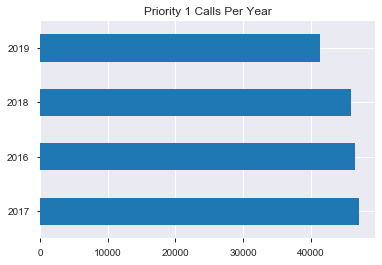

In [307]:
df['original_time_queued'].dt.year.value_counts(ascending = False).plot(kind = 'barh', title = 'Priority 1 Calls Per Year');

## Hyperparameter Tune Baseline
-__This tune didn't do anything to really improve the model overall, although some folds were better than 317__

In [349]:
def tune_model(model, param_grid, scoring_method = 'neg_mean_squared_error', n_splits = 5):
    #select features and target
    features = df.drop(['total_response_time', 'arrived_time'], axis = 1)
    labels = df['total_response_time']
    
    #returning datetime objects to strings for model training
    features['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in features['original_time_queued']]
    
    #Label Encoding features
    for x in features.columns[features.dtypes == 'object']:
        features[x] = features[x].factorize()[0]
    
    # this defines the inner cross-validation
    nr.seed(1234)
    inside = model_selection.KFold(n_splits=n_splits, shuffle = True)

    #this defines outer cross-validation
    nr.seed(4321)
    outside = model_selection.KFold(n_splits=n_splits, shuffle = True)

    ## Perform the grid search over the parameters
    nr.seed(4465)
    tuned_model = model_selection.RandomizedSearchCV(estimator = model, param_distributions = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = scoring_method,
                      return_train_score = True)

    tuned_model.fit(features, labels)
    print(tuned_model.best_estimator_.n_estimators)
    print(tuned_model.best_estimator_.max_depth)
    print(tuned_model.best_estimator_.learning_rate)

    nr.seed(478)
    cv_estimate_tuned_model = model_selection.cross_val_score(tuned_model, features, labels, 
                                 cv = outside) # Use the outside folds

    print(f'Mean {scoring_method} = %4.3f' % np.mean(cv_estimate_tuned_model))
    print(f'{scoring_method} by cv fold')
    for i, x in enumerate(cv_estimate_tuned_model):
        print('Fold %2d    %4.3f' % (i+1, x))
    
tune_model(model_lgb, param_grid = {"n_estimators": list(range(1, 4000, 10)), 'max_depth':list(range(-1, 100, 1)), 
                                    'learning_rate': (.01, .05, .10, .50, .60, .70, .80, .90, 1)}, scoring_method = 'neg_mean_squared_error', n_splits = 5)

3521
27
0.1
Mean neg_mean_squared_error = -100705.500
neg_mean_squared_error by cv fold
Fold  1    -98898.963
Fold  2    -99043.080
Fold  3    -102033.250
Fold  4    -104461.898
Fold  5    -99090.308


# Exploratory Data Analysis
- __Now that we have an idea of what our baseline model is, we can start looking into the data and creating a model that may predict more accurately__

__It appears as though assaults, 'persons down', fights (without weapons), suicides, and assisting on fire or medical response are the top types of calls__

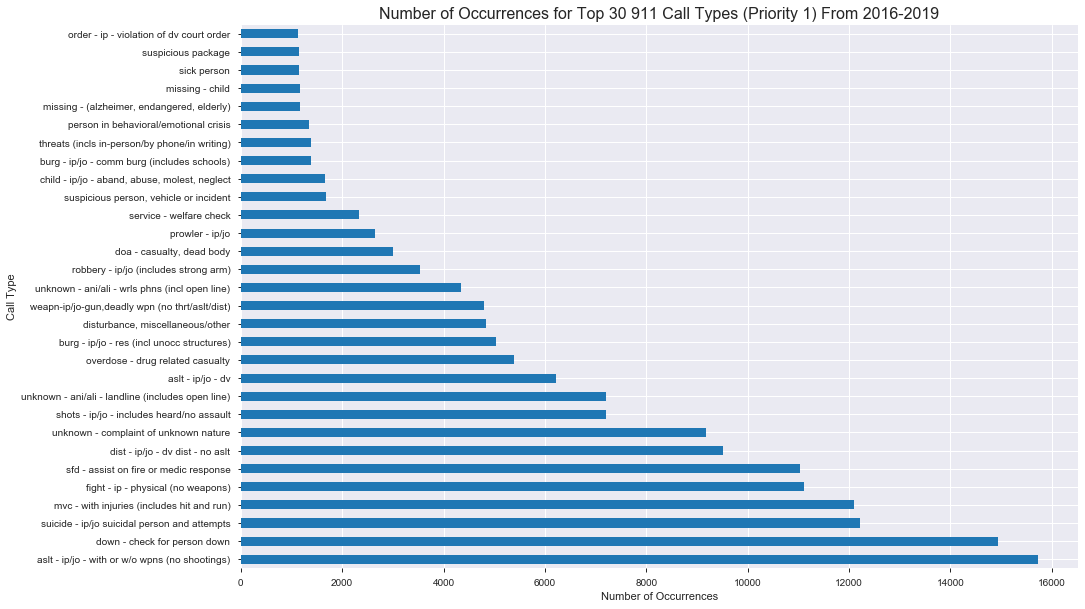

In [323]:
#looking at what types of calls are made the most (top 30)
df['initial_call_type'].value_counts().nlargest(30).plot(kind = 'barh', figsize = (15, 10))
plt.title('Number of Occurrences for Top 30 911 Call Types (Priority 1) From 2016-2019', fontsize = 16)
plt.xlabel('Number of Occurrences')
plt.ylabel('Call Type');

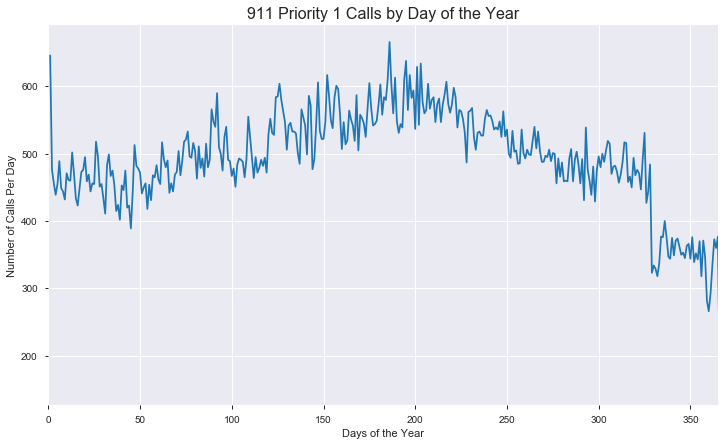

In [309]:
#looking at total amount of calls made per day of the year over the last 10 years
df.groupby(df['original_time_queued'].dt.dayofyear).total_response_time.count().plot(figsize = (12, 7))
plt.title('911 Priority 1 Calls by Day of the Year', fontsize = 16)
plt.xlabel('Days of the Year')
plt.ylabel('Number of Calls Per Day')
plt.xlim(0, 365);

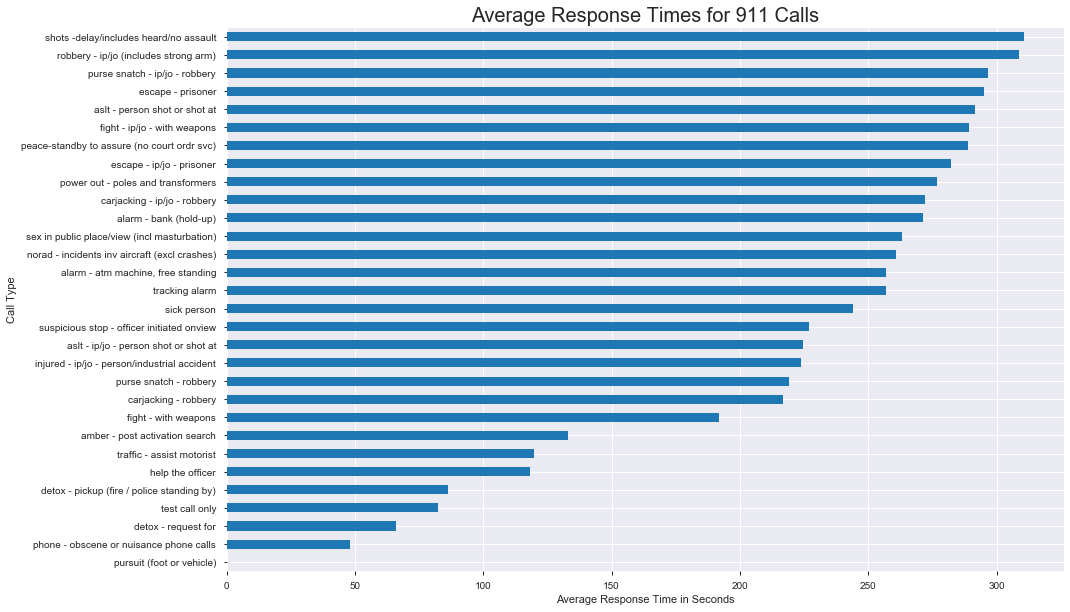

In [310]:
df.groupby('initial_call_type').total_response_time.mean().sort_values().nsmallest(30).plot(kind = 'barh', figsize = (15, 10))
plt.title('Average Response Times for 911 Calls', fontsize = 20)
plt.xlabel('Average Response Time in Seconds')
plt.ylabel('Call Type');

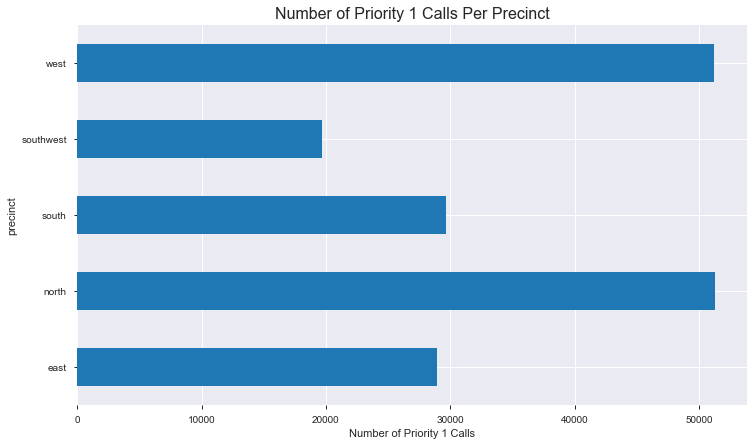

In [311]:
df.groupby('precinct').cad_event_number.count().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Priority 1 Calls Per Precinct', fontsize = 16)
plt.xlabel('Number of Priority 1 Calls');

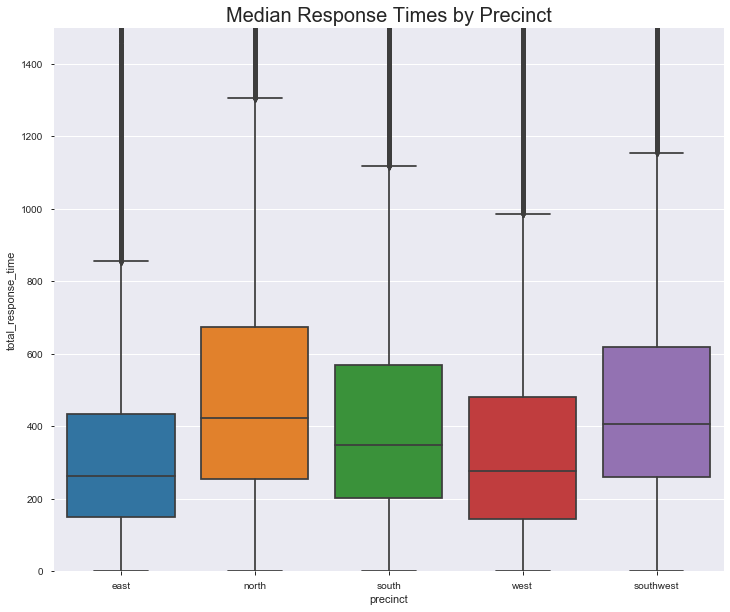

In [312]:
#looking at average repsonse times to priority 1 calls, note that there are many outliers not pictured here
plt.figure(figsize = (12, 10))
sns.boxplot(data = df, x = 'precinct', y = 'total_response_time')
plt.title('Median Response Times by Precinct', fontsize = 20)
plt.ylim(0, 1500);

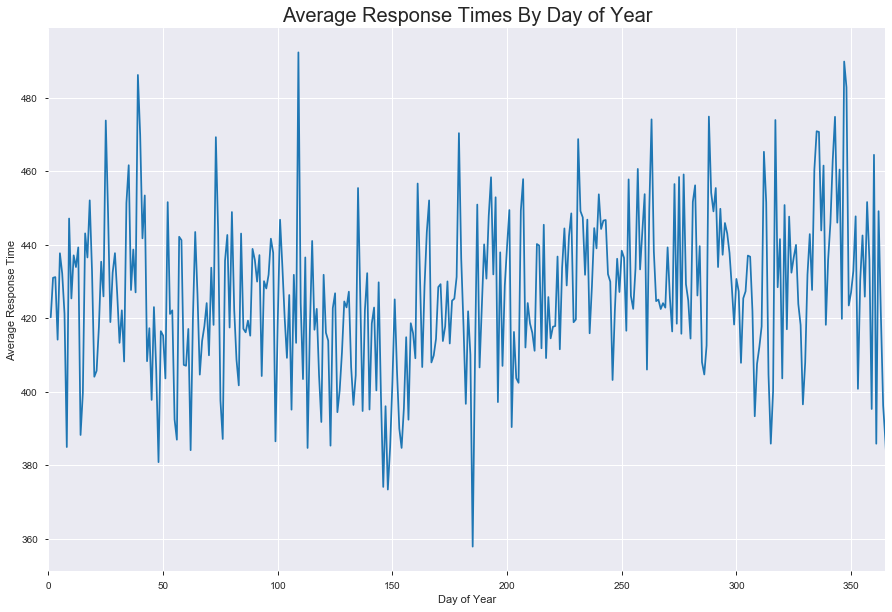

In [313]:
#seems like there is a lot of variability here, but in general there is a trend of response times increasing toward the end of the year, but decrease around Christmas
df.groupby(df['original_time_queued'].dt.dayofyear).total_response_time.mean().plot(figsize = (15, 10))
plt.title('Average Response Times By Day of Year', fontsize = 20)
plt.xlabel('Day of Year')
plt.ylabel('Average Response Time')
plt.xlim(0, 365);

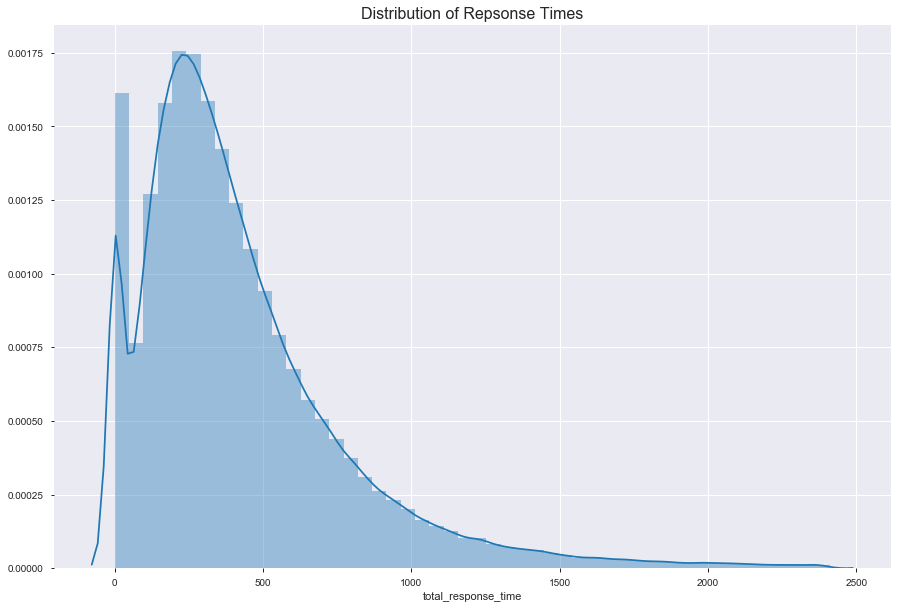

In [314]:
#looking at distribution of response times, clealy skewed here, in order to log transform we would need to remove 0s
plt.figure(figsize = (15, 10))
sns.distplot(df['total_response_time'])
plt.title('Distribution of Repsonse Times', fontsize = 16);

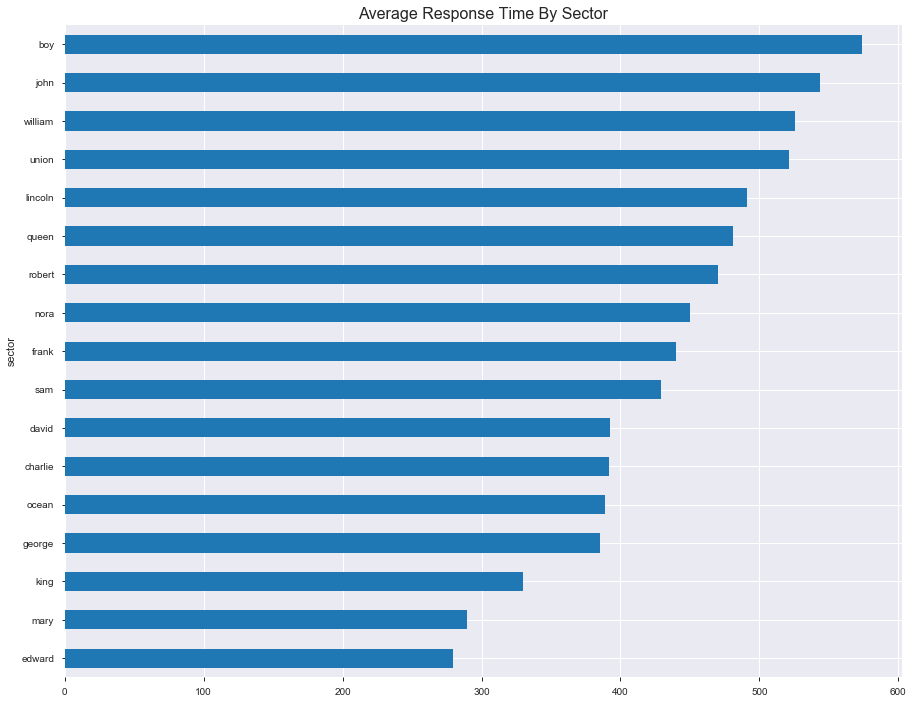

In [353]:
df.groupby('sector').total_response_time.mean().sort_values().plot(kind = 'barh', figsize = (15, 12))
plt.title('Average Response Time By Sector', fontsize = 16);